# Sales Data Analysis

This notebook performs full data cleaning and exploratory analysis on messy sales data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# Load raw data
df = pd.read_csv('../data/raw_sales_data.csv')
df.head()

,Date,Region,Product,Units Sold,Unit Price
0,2024-04-22,NaN,Phone,5.0,1000.0
1,NaN,West,NaN,9999.0,120.5
2,NaN,South,NaN,1.0,250.0
3,2024-03-18,West,NaN,1.0,5.0
4,2024-02-07,NaN,NaN,15.0,5.0


## Step 1: Clean the data

In [2]:
# Drop rows with missing date
df = df.dropna(subset=['Date'])

# Clean column names
df.columns = df.columns.str.strip()

# Remove duplicates
df = df.drop_duplicates()

# Replace empty or NaN regions/products
df['Region'] = df['Region'].fillna('Unknown')
df['Product'] = df['Product'].replace('', 'Unknown').fillna('Unknown')

# Drop rows with missing numerical values
df = df.dropna(subset=['Units Sold', 'Unit Price'])

# Convert data types
df['Date'] = pd.to_datetime(df['Date'])
df['Units Sold'] = df['Units Sold'].astype(int)
df['Unit Price'] = df['Unit Price'].astype(float)

# Remove obvious outliers
df = df[df['Units Sold'] < 5000]

# Add calculated revenue
df['Revenue'] = df['Units Sold'] * df['Unit Price']
df.head()

,Date,Region,Product,Units Sold,Unit Price,Revenue
0,2024-04-22,Unknown,Phone,5,1000.00,5000.00
3,2024-03-18,West,Unknown,1,5.00,5.00
4,2024-02-07,Unknown,Unknown,15,5.00,75.00
5,2024-04-24,North,Unknown,0,120.50,0.00
6,2024-02-14,South,Unknown,15,499.99,7499.85


## Step 2: Product categorization

In [3]:
# Create a product category mapping
category_map = {
    'Laptop': 'Tech',
    'Tablet': 'Tech',
    'Phone': 'Mobile',
    'Monitor': 'Accessories',
    'Unknown': 'Other'
}
df['Category'] = df['Product'].map(category_map).fillna('Other')
df['Month'] = df['Date'].dt.to_period('M')
df.head()

,Date,Region,Product,Units Sold,Unit Price,Revenue,Category,Month
0,2024-04-22,Unknown,Phone,5,1000.00,5000.00,Mobile,2024-04
3,2024-03-18,West,Unknown,1,5.00,5.00,Other,2024-03
4,2024-02-07,Unknown,Unknown,15,5.00,75.00,Other,2024-02
5,2024-04-24,North,Unknown,0,120.50,0.00,Other,2024-04
6,2024-02-14,South,Unknown,15,499.99,7499.85,Other,2024-02


##  Step 3:Export to Excel and CSV

In [4]:
df.to_excel("../data/cleaned_sales_data.xlsx", index=False)
df.to_csv("../data/cleaned_sales_data.csv", index=False)

## Step 4: EDA – Trends and KPIs

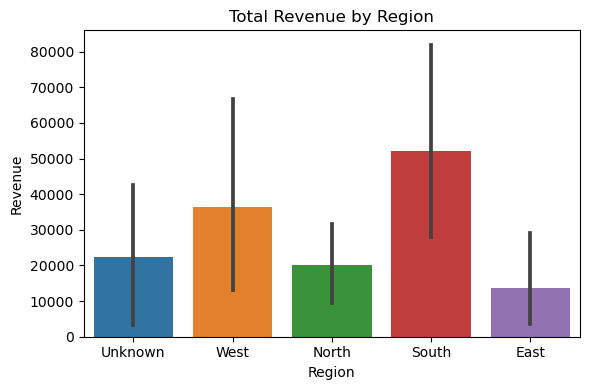

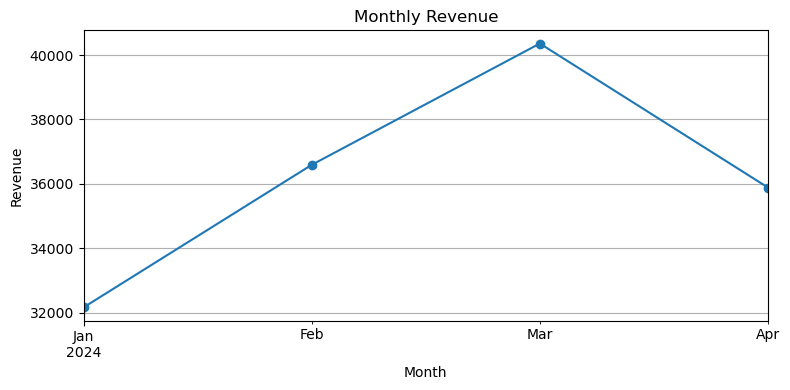

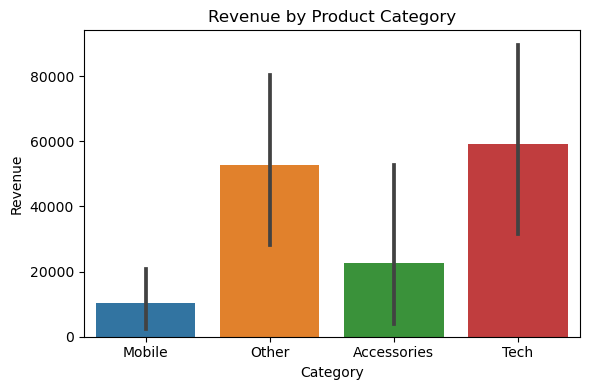

In [5]:
# Revenue by Region
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Region', y='Revenue', estimator=sum)
plt.title('Total Revenue by Region')
plt.tight_layout()
plt.savefig("../visuals/Total_Revenue_by_Region.png")
plt.show()
plt.close()


# Revenue by Month
plt.figure(figsize=(6,4))
monthly_revenue = df.groupby('Month')['Revenue'].sum()
monthly_revenue.plot(marker='o', figsize=(8,4))
plt.title('Monthly Revenue')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.savefig("../visuals/Revenue_by_Month.png")
plt.show()
plt.close()

# Revenue by Category
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Category', y='Revenue', estimator=sum)
plt.title('Revenue by Product Category')
plt.tight_layout()
plt.savefig("../visuals/Revenue_by_Product_Category.png")
plt.show()
plt.close()

## Step 5: Business KPIs

In [6]:
kpi = {
    'Total Revenue': df['Revenue'].sum(),
    'Total Units Sold': df['Units Sold'].sum(),
    'Average Order Value': df['Revenue'].sum() / len(df),
    'Revenue per Unit': df['Revenue'].sum() / df['Units Sold'].sum(),
    'Unique Products': df['Product'].nunique(),
    'Unique Regions': df['Region'].nunique()
}
for key, value in kpi.items():
    print(f"{key}: {value:,.2f}")

Total Revenue: 144,996.95
Total Units Sold: 347.00
Average Order Value: 1,907.85
Revenue per Unit: 417.86
Unique Products: 5.00
Unique Regions: 5.00


## Step 6: PDF Report

In [7]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
# Create the PDF
pdf_path = "../reports/sales_kpi_report.pdf"
c = canvas.Canvas(pdf_path, pagesize=A4)
width, height = A4

# Title
c.setFont("Helvetica-Bold", 16)
c.drawCentredString(width / 2, height - 50, "Sales KPI Report")

# Insert KPIs
c.setFont("Helvetica", 12)
y = height - 90
for key, val in kpi.items():
    c.drawString(50, y, f"{key}: {val:,.2f}")
    y -= 20

# Add chart: Total Revenue by Region
c.drawImage("../visuals/Total_Revenue_by_Region.png", 80, 360, width=400, preserveAspectRatio=True, mask='auto')
c.setFont("Helvetica-Bold", 12)
c.drawCentredString(width / 2, 350, "Total Revenue by Region")

# New page for additional charts
c.showPage()

# Add chart: Monthly Revenue
c.setFont("Helvetica-Bold", 12)
c.drawCentredString(width / 2, height - 50, "Monthly Revenue")
c.drawImage("../visuals/Revenue_by_Month.png", 80, height - 350, width=400, preserveAspectRatio=True, mask='auto')

# Add chart: Revenue by Product Category
c.setFont("Helvetica-Bold", 12)
c.drawCentredString(width / 2, 250, "Revenue by Product Category")
c.drawImage("../visuals/Revenue_by_Product_Category.png", 80, 60, width=400, preserveAspectRatio=True, mask='auto')

# Save the PDF
c.save()

print(f"PDF report saved to: {pdf_path}")

PDF report saved to: ../reports/sales_kpi_report.pdf
